In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from google.cloud import storage

In [63]:
data = pd.read_csv('monthly_data_10.csv')
data = data.fillna('')
data = data.drop_duplicates()
data = data.reset_index().drop('index', axis =1)

In [ ]:

#include ecommerce info in the binary_target -- take out after
data['is_addtocart'] = [1 if x == 1 or y == 3 else 0 for x, y in zip(data['is_addtocart'], data['eCommerceAction.action_type'])]

In [ ]:
#engineered columns
#extract the deepest split of category (not sure if this can be cut / is already included in pagepath)
data['prod_category'] = pd.Series((s.split('/')[-2] if len(s.split('/')) >=2 else s.split('/')[-1] for s in data['v2ProductCategory'])).replace('${escCatTitle}', '(not provided)').replace('${productitem.product.origCatName}', '(not provided)')
#encoding pagepath
data['path_depth'] = [len(s.split('/'))-1 for s in data['page.pagePath']]
#replace empty values with 0 for time on site
data['timeOnSite'] = data['timeOnSite'].replace('', 0)
#is content group for this hit the same as the previous hit 
data['same_content_group'] = data['contentGroup.contentGroup2'] ==data[ 'contentGroup.previousContentGroup2']

In [83]:
def to_bucket(df, file_name):
    try: 
        df.to_csv(f'{file_name}.csv', mode = 'x', index= False)
    except ValueError:
        print('file already exists') 
    client = storage.Client()
    bucket = client.get_bucket('huang-capstone-york-bb-cohort-unique')
    bucket.blob(f'{file_name}.csv').upload_from_filename(f'{file_name}.csv')

In [ ]:
#export data for model training
export = data[['is_addtocart', 'v2ProductName', 'productPrice', 'localProductPrice',
       'productListName', 'hitNumber', 'time', 'hour', 'minute', 'type',
       'page.pagePath', 'appInfo.screenName', 'eventInfo.eventCategory',
       'eCommerceAction.step', 'social.hasSocialSourceReferral',
       'contentGroup.contentGroup2', 'contentGroup.previousContentGroup2',
       'source', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory',
       'continent', 'subContinent', 'country', 'networkDomain', 'hits',
       'pageviews', 'timeOnSite', 'newVisits', 'prod_category', 'path_depth',
       'same_content_group']]
to_bucket(export, 'feature_eng1')

In [ ]:
"""After removing majority-null and duplicate columns, there are 46 features.
"""

In [110]:
#targets
raw_target = data['event_action'][data['event_action'] != '']
encoded = data['eCommerceAction.action_type'][data['eCommerceAction.action_type'] != 0]
binary_target = data['is_addtocart'] 

In [114]:
""" 8.76% of events are Add to Cart """ 

,count,percent
eCommerceAction.action_type,,
1,38478,37.000212
2,31416,30.209435
5,18299,17.596207
3,9109,8.759159
6,5396,5.188761
4,1296,1.246226


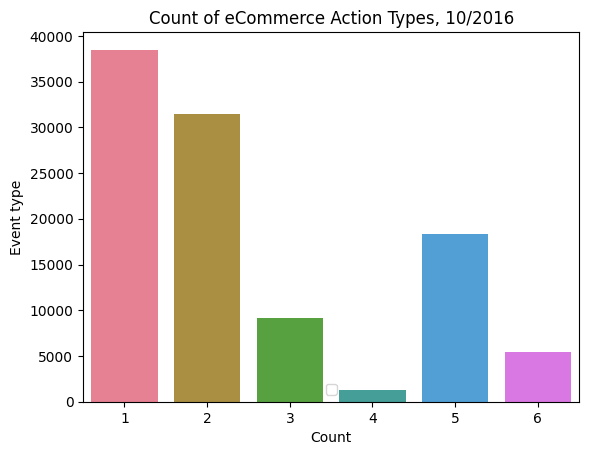

In [112]:
#distribution of events based on ecommerce action type
ax = sns.barplot(y = encoded.value_counts().values, 
            x = encoded.value_counts().index, 
            hue = encoded.value_counts().index , 
            palette = sns.color_palette('husl'), dodge = False)
plt.legend([])
plt.xlabel("Count")
plt.ylabel("Event type")
plt.title("Count of eCommerce Action Types, 10/2016")
plt.savefig('figures/hist_action_types.png', bbox_inches="tight")
event_counts = pd.DataFrame(encoded.value_counts())
event_counts['percent'] = event_counts['count'] /len(encoded.index)*100
event_counts.head(6)

,count,percent
event_action,,
Quickview Click,31025,48.263900
Promotion Click,13014,20.245170
Add to Cart,9107,14.167263
Product Click,7452,11.592670
Onsite Click,2388,3.714881
Remove from Cart,1296,2.016116


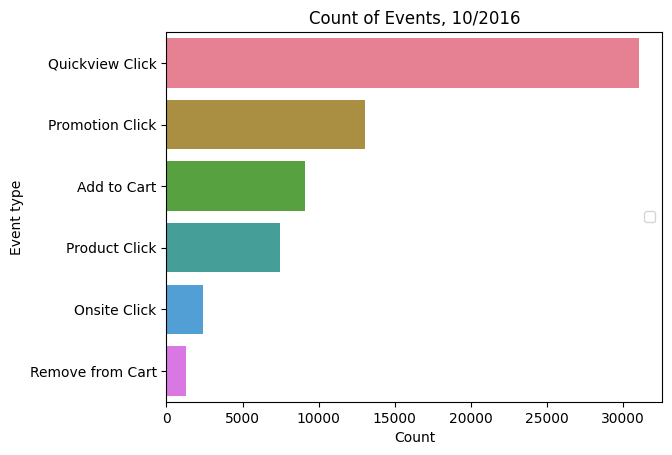

In [113]:
#distribution of events
ax = sns.barplot(y = raw_target.value_counts().index, 
            x = raw_target.value_counts().values, 
            hue = raw_target.value_counts().index , 
            palette = sns.color_palette('husl'), dodge = False)
plt.legend([])
plt.xlabel("Count")
plt.ylabel("Event type")
plt.title("Count of Events, 10/2016")
plt.savefig('figures/hist_ecommerce_action.png', bbox_inches="tight")


event_counts = pd.DataFrame(raw_target.value_counts())
event_counts['percent'] = event_counts['count'] /len(raw_target.index)*100
event_counts.head(6)


In [304]:
"""
-Overall events is highest at a path depth of 3
-The distribution of add to cart clicks is also highest at 3 and then 4; for Add to Cart, majority of the path depths are 3 to 4
    - Logically this makes sense because the deeper in the path you are the more likely you are to be on a product. 
"""

event_action  Add to Cart  Onsite Click  Product Click  Promotion Click  \
path_depth                                                                
1                   605.0         366.0          365.0          12950.0   
2                  1106.0         935.0         1190.0              NaN   
3                  3813.0         696.0         4417.0              NaN   
4                  3440.0         391.0         1480.0             64.0   
5                   143.0           NaN            NaN              NaN   

event_action  Quickview Click  Remove from Cart  
path_depth                                       
1                      1913.0            1296.0  
2                      5410.0               NaN  
3                     16463.0               NaN  
4                      7239.0               NaN  
5                         NaN               NaN  


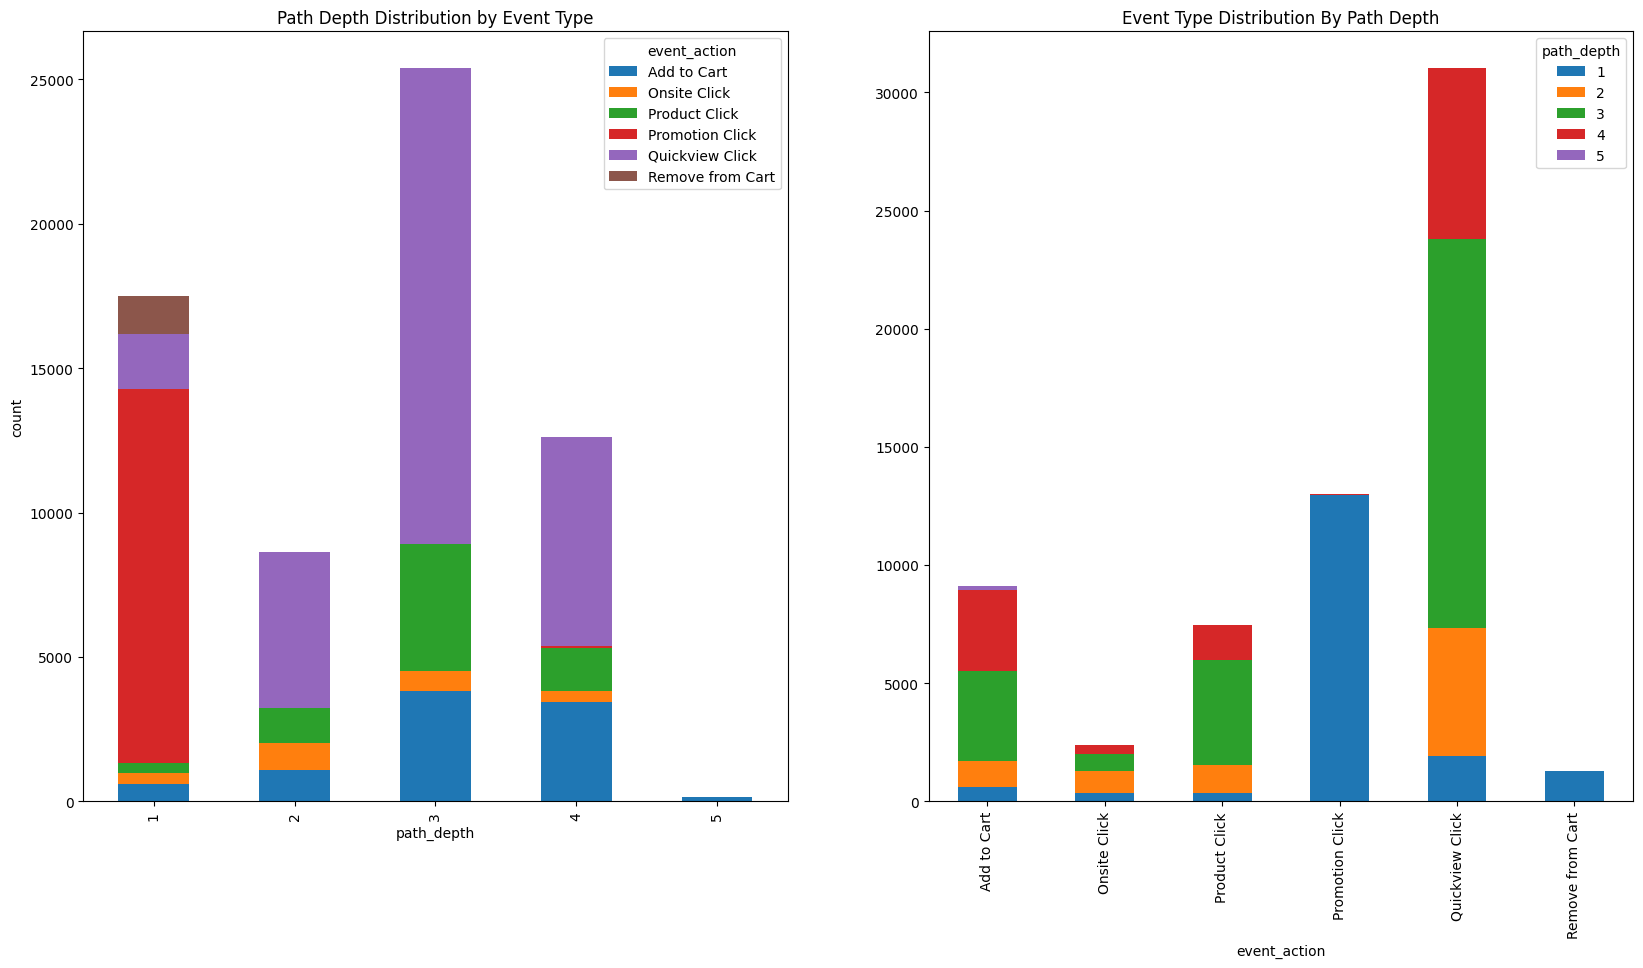

In [114]:
#path depth distribution grouped by event type 
#concat path depth and target values, then group by the path depth and get the value counts. unstack unnests it from a tuple
fig,ax = plt.subplots(1,2, figsize = (20,10))
path_depth_dist = pd.concat([data['path_depth'], raw_target],axis= 1).groupby('path_depth')['event_action'].value_counts().unstack()
#plot a stacked bar plot
path_depth_dist.plot(kind = 'bar', stacked = True, ax = ax[0])
ax[0].set_ylabel('count')
ax[0].set_title('Path Depth Distribution by Event Type')
path_depth_dist1 = pd.concat([data['path_depth'], raw_target],axis= 1).groupby('event_action')['path_depth'].value_counts().unstack()
path_depth_dist1.plot(kind = 'bar', stacked = True, ax = ax[1])
ax[1].set_title('Event Type Distribution By Path Depth')
print (path_depth_dist)
plt.savefig('figures/path_depth.png', bbox_inches="tight")


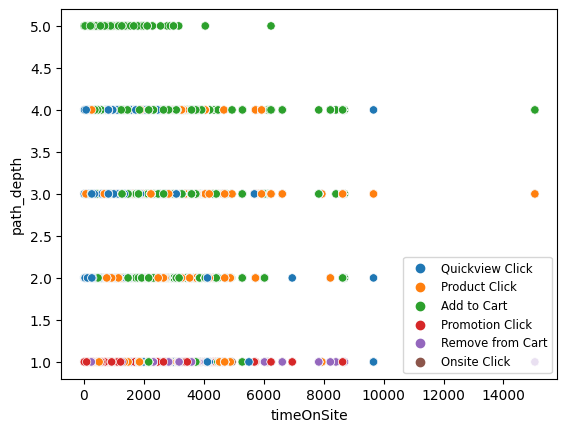

In [ ]:
#distribution of sitetime and path depth
ax = sns.scatterplot(data = data, x ='timeOnSite', y = 'path_depth', hue = 'event_action')
ax.legend(fontsize = 'small')


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


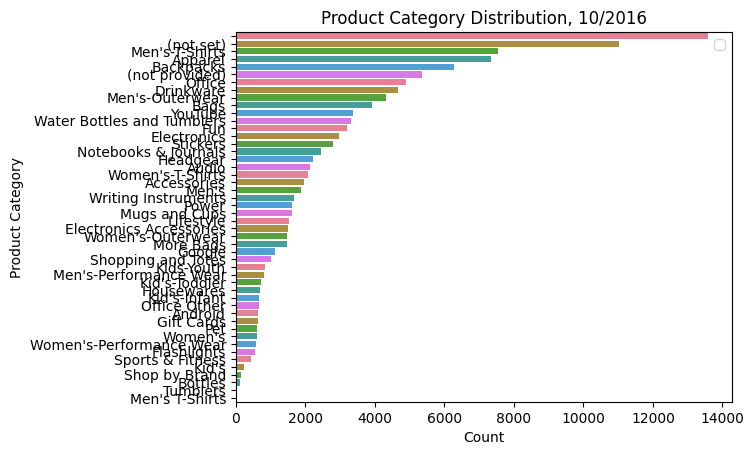

In [117]:
#product category distribution
plt.plot(figsize = (20,40))
sns.barplot(y = data['prod_category'].value_counts().index, 
            x = data['prod_category'].value_counts().values, 
            hue = data['prod_category'].value_counts().index , 
            palette = sns.color_palette('husl'), dodge = False)
plt.legend([])
plt.xlabel("Count")
plt.ylabel("Product Category")
plt.title("Product Category Distribution, 10/2016")


In [ ]:
temp_x = X['timeOnSite']

In [ ]:
sitetime = pd.concat([temp_x, raw_target], axis = 1)

In [118]:
"""
Longer time on site for add to cart and remove from cart compared to other events.
Seems like this may be good for distinguishing cart actions from other events but not for distinguishing between add and remove
"""

In [119]:
sns.boxplot(x=raw_target, y = data['timeOnSite'], showfliers = False)
plt.xticks(rotation = 90)
plt.title("Distribution of Time on Site by Event Type", pad = 20)
plt.text(0.5, 1.02, '*Outliers excluded', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig('figures/site_time.png', bbox_inches="tight")